In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.constants import c, k_B, M_sun, G, m_p, sigma_sb, m_p
import astropy.units as u
from scipy.integrate import solve_ivp
from scipy.integrate import LSODA
import numpy as np
import numba
import sys

sys.path.append('../Numerical_methods')
from matrix_calculator import A_matrix
from scheme_calculator import forward_backward
from bachelor_funcs import Σ_initial, r_array, get_1_dev_irr

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 12}
mpl.rc('font', **font)

### Equation 10 from Suzuki

$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    + r^2\alpha_{\phi z}(\rho c_s^2)_{\textrm{mid}}
    \right\}\right]
    + C_{\textrm{w}}(\rho c_s)_{\textrm{mid}}
    \;=\;0$$

$$
\Omega\approx\Omega_K=\sqrt{\frac{GM_*}{r^3}}
$$    

$$
c_s^2=\frac{k_BT}{\mu m_H}
$$

#### Neglecting disc wind and torque:
$$  \frac{\partial\Sigma}{\partial t} - \frac{1}{r}\frac{\partial}{\partial r}\left[
    \frac{2}{r\Omega}\left\{
    \frac{\partial}{\partial r}\left(
    r^2\Sigma\alpha_{r\phi}c_s^2
    \right)
    \right\}\right]
    
    \;=\;0$$

#### From B.10:
$$\sigma_\textrm{SB}T^4=\frac{3}{4}\Omega\Sigma\bar{\alpha_{r\phi}}c_s^2$$

$$\Rightarrow \quad c_s^6\;=\;\frac{1}{\sigma_\textrm{SB}}
\left(\frac{\mu m_{H}}{K_B}\right)^{-4}
\frac{3}{4}\Omega\Sigma \bar{\alpha_{r\phi}}
$$

In [47]:
μ = 2.34    #(Hayashi 1981)

In [48]:
def Omega_kep(r):
    return np.sqrt((G * M_sun) / r**3)


def c_s(Ω,  Σ, α_rφ = 8e-3):
    return ((sigma_sb**(-1) * (μ * m_p / k_B)**(-4) * 3/4 * Ω * Σ * α_rφ)**(1/6)).to('m/s')

In [49]:
r = r_array * u.au
c_s(Omega_kep(r), Σ_initial(r))[0]

<Quantity 9063.54972517 m / s>

### Imposing the boundary condition $\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$

$$\frac{\partial}{\partial r}(\Sigma r^{3/2})=0$$
$$\Rightarrow\frac{\partial}{\partial r}(\Sigma)\cdot r^{3/2}\;+\;\frac{3}{2}\Sigma r^{1/2}=0$$
$$\Sigma r^{2}=-\frac{2}{3}\;r^{3}\;\frac{\partial}{\partial r}\Sigma$$


In [50]:
α_rφ = 8e-3


def one_alpha(Σ):
    boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

In [51]:
one_alpha(Σ_initial(r))

<Quantity [1.78760930e+008, 8.35061392e+007, 2.71509826e+007, ...,
           5.92711292e-197, 3.65032494e-197, 1.76177695e-197] mg / (cm2 yr)>

In [52]:
α_rφ = 8e-3
def one_alpha_diff(t, Σ):
    Σ = Σ *  u.g * u.cm**-2
    #boundary = -2/3 * r**(3) * get_1_dev_irr(Σ)
    
    inner_1 = Σ * r**(2)
    #inner_1[0] = boundary[0]
    #inner_1[-1] = boundary[-1]

    inner_2 = α_rφ * c_s(Omega_kep(r), Σ)**2

    inner_dev = get_1_dev_irr(inner_1 * inner_2)
    
    outer_dev = get_1_dev_irr(2 / (r *Omega_kep(r)) * inner_dev)

    #outer_dev[0] = 0
    #outer_dev[-1] = 0

    return ((r**(-1) * outer_dev * u.au**(-2)).to('mg/(yr * cm^2)'))

#### "one_alpha_diff" return in terms of:
$$\left[\frac{g}{cm^2}\frac{1}{kyr}\right]$$

In [53]:
# Default values for tolerance:
# rtol: 1e-3 
# atol: 1e-6 

times = np.arange(0, 100, 0.1)

sol = solve_ivp(one_alpha_diff, [times[0], times[-1]], y0 = Σ_initial(r).value, method = 'LSODA', t_eval = times, atol=1e-4, rtol=1e-6)
sol

C:\Users\chris\anaconda3\lib\site-packages\astropy\units\quantity.py:486: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
C:\Users\chris\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1350: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


  message: 'Unexpected istate in LSODA.'
     nfev: 40714
     njev: 20
      nlu: 20
      sol: None
   status: -1
  success: False
        t: array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8])
 t_events: None
        y: array([[1.69943343e+007, 1.77560841e+007, 1.64166180e+007, ...,
        6.01346733e+006, 3.45570235e+006, 3.21900122e+005],
       [6.00640204e+006, 7.41922264e+006, 7.04740006e+006, ...,
        3.09242532e+006, 2.20796919e+006, 1.19523115e+006],
       [2.69165032e+006, 3.64680020e+006, 3.58128351e+006, ...,
        1.81688043e+006, 1.43857590e+006, 9.92670772e+005],
       ...,
       [4.74636111e-147, 4.74636111e-147, 4.74636111e-147, ...,
        4.74636111e-147, 4.74636111e-147, 4.74636111e-147],
       [3.39663825e-147, 3.39663825e-147, 3.39663825e-147, ...,
        3.39663825e-147, 3.39663825e-147

In [54]:
np.shape(sol.y)

(2003, 39)

[Text(0.5, 0, 'r [AU]'),
 Text(0, 0.5, 'Σ(r, t=0) [$g/cm^2$]'),
 Text(0.5, 1.0, 'Initial condition for surface density\n$M_{disc}=0.11M_{sun}$'),
 None,
 None,
 (0.01, 10000000.0),
 (0.01, 300)]

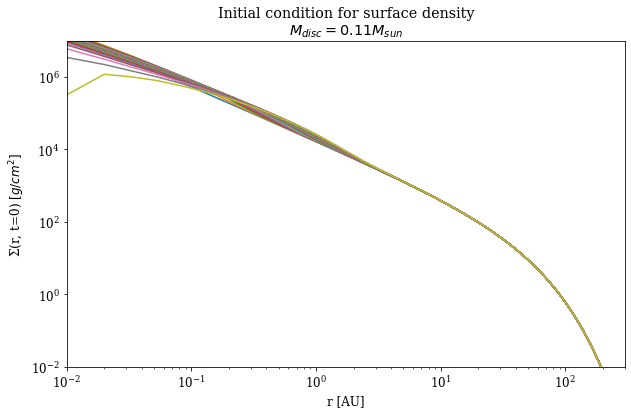

In [55]:
fig, axs = plt.subplots(figsize = (10,6))
for Σ in range(len(sol.y[0,:])):
    axs.loglog(r, sol.y[:,Σ])

axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t=0) [$g/cm^2$]', 
title = 'Initial condition for surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e7), xlim = (0.01, 300))

In [56]:
sol_lsoda = LSODA(one_alpha_diff, t0 = 0, y0 = Σ_initial(r).value, t_bound = times[-1], rtol = 0.3 , atol = 1000)
sol_lsoda.t

0

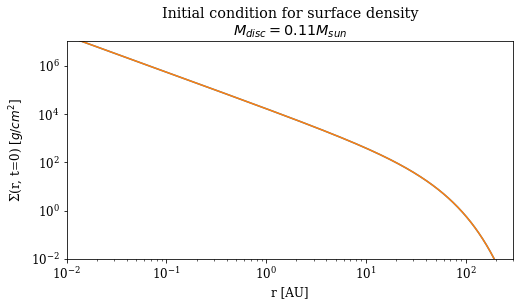

In [57]:
fig, axs = plt.subplots(figsize = (8,4))
axs.set(xlabel = 'r [AU]', ylabel = 'Σ(r, t=0) [$g/cm^2$]', 
title = 'Initial condition for surface density\n$M_{disc}=0.11M_{sun}$', yscale = 'log', xscale = 'log', ylim = (1e-2,1e7), xlim = (0.01, 300))

axs.plot(r, Σ_initial(r), label = 'Initial condition for Σ')
axs.loglog(r_array, sol_lsoda.y)